In [435]:
import numpy as np
import pandas as pd
import pyodbc
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import scipy.stats as stats
from astropy.stats import median_absolute_deviation
from scipy.stats import boxcox
import statistics
import datetime
import time
rcParams['figure.figsize'] = 10, 6

In [436]:
sql_conn = pyodbc.connect('''DRIVER={ODBC Driver 13 for SQL Server};
                            SERVER=srvmsp063;
                            DATABASE=LINX_DW;
                           Trusted_Connection=yes''')
marca="LE LIS BLANC DEUX"

In [504]:
query = '''WITH
VENDA_HORA_CTE as (

   SELECT A.DATA_DTTIME, A.HORA, A.MINUTO
      ,VLF = Sum (A.VALOR_VENDA - A.VALOR_TROCA - A.DESCONTO_VENDA - A.DESCONTO_TROCA)
   FROM FatoVendas A
   JOIN DimFiliais B on A.CODIGO_FILIAL = B.CODIGO_FILIAL and B.CANAL = 'REDE'
   JOIN DimProdutos C on A.PRODUTO = C.PRODUTO
   WHERE A.DATA_DTTIME = DATEADD(DAY, 0, Cast(GETDATE() as date))
   and A.DESC_REDE_LOJAS = '{var}'
   GROUP BY A.DATA_DTTIME, A.HORA, A.MINUTO
),

TBL_HORA_CTE AS (
   SELECT 11 AS HORA, 1 AS ID UNION ALL
   SELECT 12 AS HORA, 1 AS ID UNION ALL
   SELECT 13 AS HORA, 1 AS ID UNION ALL
   SELECT 14 AS HORA, 1 AS ID UNION ALL
   SELECT 15 AS HORA, 1 AS ID UNION ALL
   SELECT 16 AS HORA, 1 AS ID UNION ALL
   SELECT 17 AS HORA, 1 AS ID UNION ALL
   SELECT 18 AS HORA, 1 AS ID UNION ALL
   SELECT 19 AS HORA, 1 AS ID UNION ALL
   SELECT 20 AS HORA, 1 AS ID UNION ALL
   SELECT 21 AS HORA, 1 AS ID UNION ALL
   SELECT 22 AS HORA, 1 AS ID
),

TBL_MINUTO_CTE AS(
	SELECT 00 AS MINUTO, 1 AS ID UNION ALL
	SELECT 15 AS MINUTO, 1 AS ID UNION ALL
	SELECT 30 AS MINUTO, 1 AS ID UNION ALL
	SELECT 45 AS MINUTO, 1 AS ID
),

TBL_DIA_CTE AS (
   SELECT A.DATA_DTTIME, 1 AS ID
   FROM DimCalendario A
   WHERE A.DATA_DTTIME = cast(getdate() as date)
),

TBL_DIA_HORA_CTE AS (
   SELECT A.DATA_DTTIME
		, B.HORA, 1 AS ID
   FROM TBL_DIA_CTE A
   FULL OUTER JOIN TBL_HORA_CTE B ON A.ID = B.ID
   GROUP BY A.DATA_DTTIME, B.HORA
),

TBL_DIA_HORA_MINUTO_CTE AS(
	SELECT A.DATA_DTTIME, A.HORA, B.MINUTO
	FROM TBL_DIA_HORA_CTE A
	FULL OUTER JOIN TBL_MINUTO_CTE B ON A.ID = B.ID
	GROUP BY A.DATA_DTTIME, A.HORA, B.MINUTO
),

VENDA_CONCATEN as(
	SELECT  A.DATA_DTTIME
			, A.HORA
			,A.MINUTO
			, B.VLF
	FROM TBL_DIA_HORA_MINUTO_CTE A
	LEFT JOIN VENDA_HORA_CTE B on A.DATA_DTTIME=B.DATA_DTTIME AND A.HORA=B.HORA AND A.MINUTO=B.MINUTO
),

VENDA_HORA_ACC_CTE as (
	SELECT A.DATA_DTTIME, A.HORA, A.MINUTO
		, VLF_ACC = Sum(A.VLF) over (PARTITION BY A.HORA ORDER BY A.MINUTO)
	FROM VENDA_CONCATEN A
	GROUP BY A.DATA_DTTIME, A.HORA, A.VLF, A.MINUTO
)

SELECT A.DATA_DTTIME
   ,A.HORA
   ,A.MINUTO
   ,ISNULL(A.VLF_ACC,0) as VLF
FROM VENDA_HORA_ACC_CTE A
            '''.format(var=marca)#manipulacao da base de dados

In [505]:
dataset = pd.read_sql(query, sql_conn)
dataset['DATA_DTTIME'] = dataset['DATA_DTTIME'].map(lambda x: str(x)[:-9])
lista2=[]
for data,row,min in zip(dataset['DATA_DTTIME'],dataset['HORA'], dataset['MINUTO']):
    row=str(data)+' '+str(row)+':'+str(min)
    lista2.append(row)
i=0

for row in dataset['VLF']:
    if(i!=0):
        dataset.loc[dataset.index[i], 'VLF'] = dataset.loc[dataset.index[i-1], 'VLF'] + row
    i=i+1
lista=[]

dataset3=dataset
hora = int((int((((datetime.datetime.now().hour * 60 + datetime.datetime.now().minute) - 7.5) / 15)) * 15) / 60)
minuto = (int((((datetime.datetime.now().hour * 60 + datetime.datetime.now().minute) - 7.5) / 15)) * 15) % 60
i=0
hora = 13
minuto=30
dataset2=dataset
     
for time,min in zip(dataset['HORA'],dataset['MINUTO']):
    time = int(time)
    min = int(min)
    if(time>hora or (time==hora and min>minuto)):
        dataset=dataset.drop(i)
    else:
        dataset2=dataset2.drop(i)
    if(time>(hora + 2)):
        dataset3=dataset3.drop(i)
    i=i+1
dataset['HORA'] = pd.Series(lista2)
dataset=dataset.drop('DATA_DTTIME', axis=1)
dataset=dataset.drop('MINUTO', axis=1)

dataset2['HORA'] = pd.Series(lista2)
dataset2=dataset2.drop('DATA_DTTIME', axis=1)
dataset2=dataset2.drop('MINUTO', axis=1)
dataset2=dataset2.drop('VLF', axis=1)

dataset3['HORA'] = pd.Series(lista2)
dataset3=dataset3.drop('DATA_DTTIME', axis=1)
dataset3=dataset3.drop('MINUTO', axis=1)

dataset['HORA'] = pd.to_datetime(dataset['HORA'], format='%Y-%m-%d %H:%M')
indexedDataset = dataset.set_index(['HORA'])

dataset3['HORA'] = pd.to_datetime(dataset3['HORA'], format='%Y-%m-%d %H:%M')
indexedDataset2 = dataset3.set_index(['HORA'])
print(indexedDataset)
print(indexedDataset2)


                     VLF
HORA                    
2019-02-18 11:00:00  0.0
2019-02-18 11:15:00  0.0
2019-02-18 11:30:00  0.0
2019-02-18 11:45:00  0.0
2019-02-18 12:00:00  0.0
2019-02-18 12:15:00  0.0
2019-02-18 12:30:00  0.0
2019-02-18 12:45:00  0.0
2019-02-18 13:00:00  0.0
2019-02-18 13:15:00  0.0
2019-02-18 13:30:00  0.0
                     VLF
HORA                    
2019-02-18 11:00:00  0.0
2019-02-18 11:15:00  0.0
2019-02-18 11:30:00  0.0
2019-02-18 11:45:00  0.0
2019-02-18 12:00:00  0.0
2019-02-18 12:15:00  0.0
2019-02-18 12:30:00  0.0
2019-02-18 12:45:00  0.0
2019-02-18 13:00:00  0.0
2019-02-18 13:15:00  0.0
2019-02-18 13:30:00  0.0
2019-02-18 13:45:00  0.0
2019-02-18 14:00:00  0.0
2019-02-18 14:15:00  0.0
2019-02-18 14:30:00  0.0
2019-02-18 14:45:00  0.0
2019-02-18 15:00:00  0.0
2019-02-18 15:15:00  0.0
2019-02-18 15:30:00  0.0
2019-02-18 15:45:00  0.0


Lambda: 0.539475


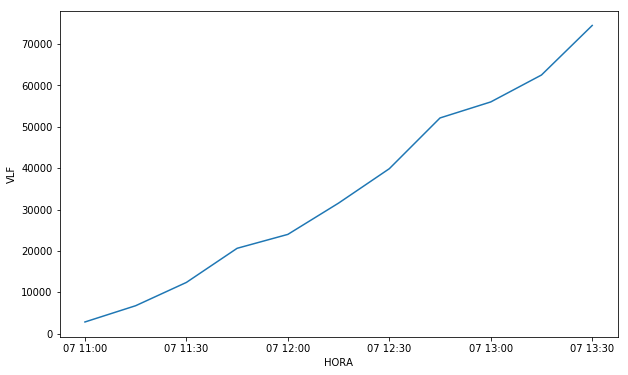

In [485]:
plt.xlabel("HORA")
plt.ylabel("VLF")
plt.plot(indexedDataset)
indexedDataset['VLF'], lam = boxcox(indexedDataset['VLF'])
print('Lambda: %f' % lam)


In [486]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determinando rolling statistics
    movingAverage = timeseries.rolling(window=4).mean()
    movingSTD = timeseries.rolling(window=4).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['VLF'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations  Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

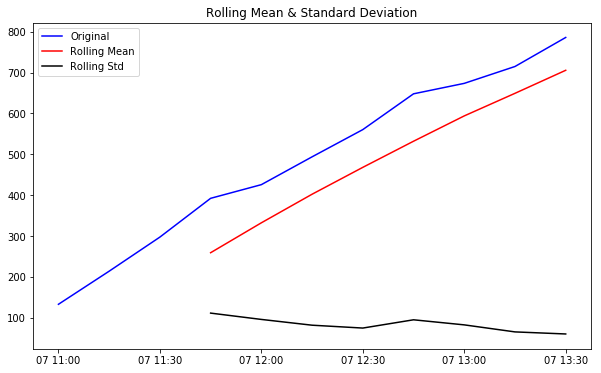

Results of Dickey-Fuller Test:
Test Statistic                   0.000000
p-value                          0.958532
#Lags Used                       7.000000
Number of Observations  Used     3.000000
Critical Value (1%)            -10.417191
Critical Value (5%)             -5.778381
Critical Value (10%)            -3.391681
dtype: float64


C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [487]:
test_stationarity(indexedDataset)

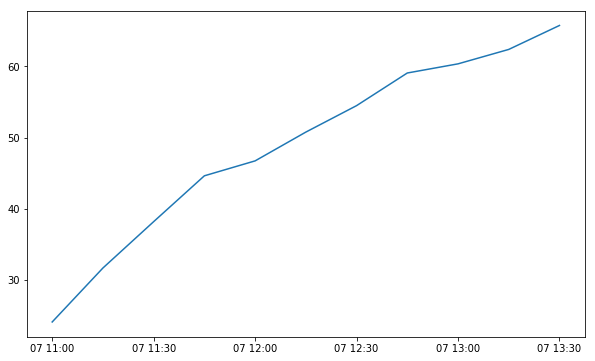

In [488]:
indexedDataset_logScale=indexedDataset
indexedDataset_logScale['VLF'] = boxcox(indexedDataset['VLF'], lmbda=lam)
#indexedDataset_logScale=np.sqrt(indexedDataset)
plt.plot(indexedDataset_logScale)

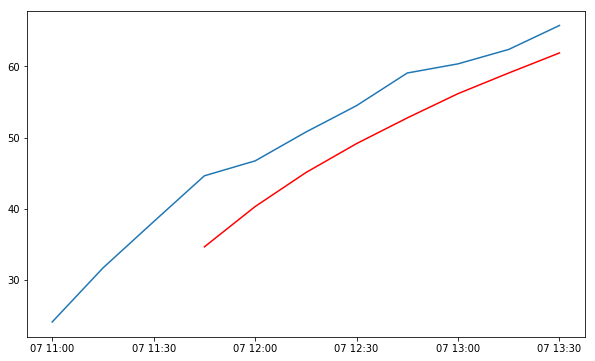

In [489]:
movingAverage = indexedDataset_logScale.rolling(window=4).mean()
movingSTD = indexedDataset_logScale.rolling(window=4).std
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [490]:
#-------------------------------------

datasetLogDiffShifting2 = np.diff(indexedDataset_logScale['VLF'],n=2)
#predictions_ARIMA_diff['HORA']=indexedDataset_logScale['HORA']
#print(datasetLogDiffShifting)
#plt.plot(datasetLogDiffShifting)
datasetLogDiffShifting = pd.DataFrame(dataset['HORA'], columns=['HORA'])
#datasetLogDiffShifting=datasetLogDiffShifting.drop(0)
#datasetLogDiffShifting=datasetLogDiffShifting.drop(1)
datasetLogDiffShifting=datasetLogDiffShifting.reset_index(drop=True)
datasetLogDiffShifting['VLF']=pd.Series(datasetLogDiffShifting2)
datasetLogDiffShifting = datasetLogDiffShifting.set_index(['HORA'])
print(datasetLogDiffShifting)


                          VLF
HORA                         
2019-02-07 11:00:00 -1.071687
2019-02-07 11:15:00 -0.069096
2019-02-07 11:30:00 -4.350299
2019-02-07 11:45:00  1.950215
2019-02-07 12:00:00 -0.329031
2019-02-07 12:15:00  0.871357
2019-02-07 12:30:00 -3.303720
2019-02-07 12:45:00  0.741615
2019-02-07 13:00:00  1.341036
2019-02-07 13:15:00       NaN
2019-02-07 13:30:00       NaN


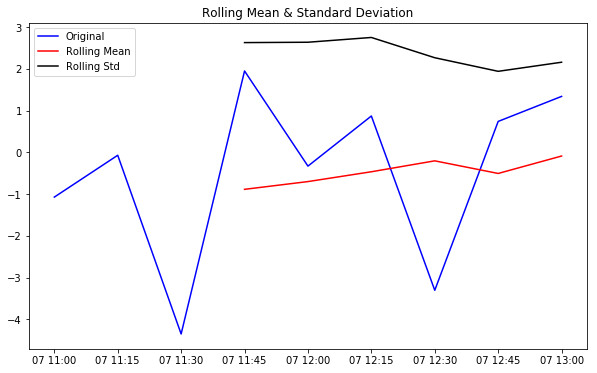

Results of Dickey-Fuller Test:
Test Statistic                 -3.889532
p-value                         0.002113
#Lags Used                      0.000000
Number of Observations  Used    8.000000
Critical Value (1%)            -4.665186
Critical Value (5%)            -3.367187
Critical Value (10%)           -2.802961
dtype: float64


C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\linear_model.py:846: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [491]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)


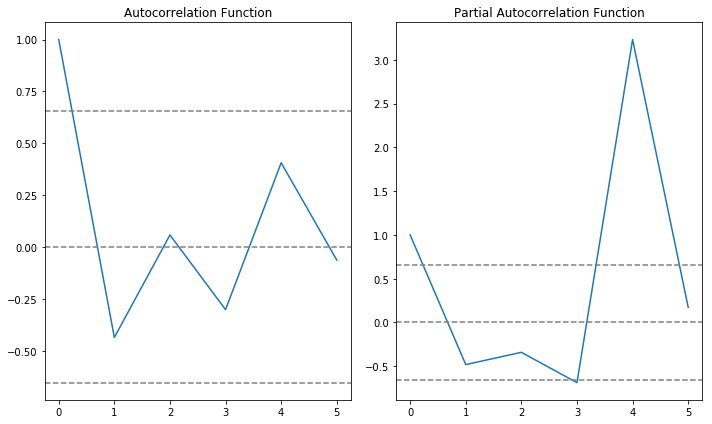

In [492]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogDiffShifting, nlags=5)
lag_pacf = pacf(datasetLogDiffShifting, nlags=5, method='ols')

#Plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


In [493]:

import seaborn
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
print(datasetLogDiffShifting)
print(indexedDataset_logScale)


                          VLF
HORA                         
2019-02-07 11:00:00 -1.071687
2019-02-07 11:15:00 -0.069096
2019-02-07 11:30:00 -4.350299
2019-02-07 11:45:00  1.950215
2019-02-07 12:00:00 -0.329031
2019-02-07 12:15:00  0.871357
2019-02-07 12:30:00 -3.303720
2019-02-07 12:45:00  0.741615
2019-02-07 13:00:00  1.341036
                           VLF
HORA                          
2019-02-07 11:00:00  24.066104
2019-02-07 11:15:00  31.655390
2019-02-07 11:30:00  38.172988
2019-02-07 11:45:00  44.621491
2019-02-07 12:00:00  46.719695
2019-02-07 12:15:00  50.768114
2019-02-07 12:30:00  54.487503
2019-02-07 12:45:00  59.078248
2019-02-07 13:00:00  60.365273
2019-02-07 13:15:00  62.393914
2019-02-07 13:30:00  65.763590


C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:

C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.

C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.

C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:

C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:

C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.

C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:

C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:

C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.

C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:

C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.

C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:

C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.

C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


aic: 39.03430 | order: (3, 2, 0)
--------------------

39.03429915192312 (3, 2, 0)
--------------------



C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.

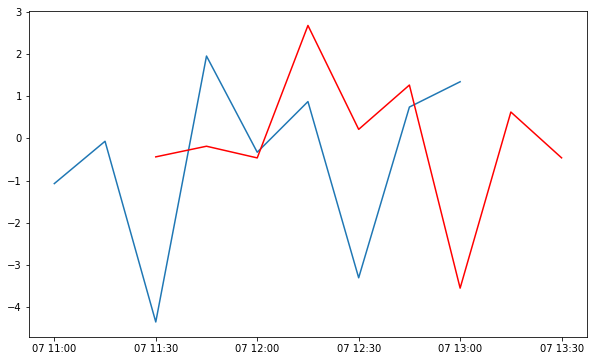

In [495]:
best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(5) # [0,1]
for i in pq_rng: 
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = ARIMA(indexedDataset_logScale, order=(i,d,j)).fit(disp=-1)
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
print("--------------------\n")
print(best_aic, best_order)
print("--------------------\n")

# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
plt.plot(datasetLogDiffShifting)
plt.plot(best_mdl.fittedvalues, color='red')

#_ = seaborn.tsplot(best_mdl.resid)
#plt.plot(datasetLogDiffShifting, color='red')

In [496]:
print(len(best_mdl.fittedvalues))
tam = len(best_mdl.fittedvalues) + 6

9


(array([69.11090421, 69.46097795, 69.36727886, 70.23580354, 71.90226995,
       71.28047166]), array([0.93655949, 1.52184752, 2.00283313, 2.31631446, 2.99514973,
       3.78378346]), array([[67.27528135, 70.94652708],
       [66.47821162, 72.44374429],
       [65.44179805, 73.29275966],
       [65.69591062, 74.77569646],
       [66.03188436, 77.77265554],
       [63.86439236, 78.69655096]]))


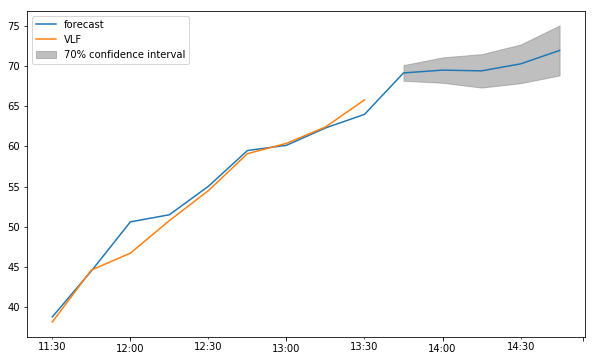

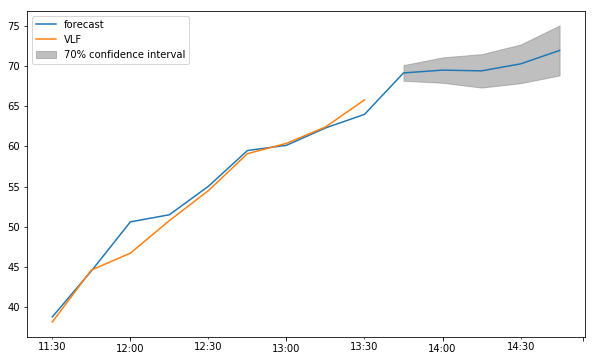

In [497]:
print(best_mdl.forecast(steps=6))
best_mdl.plot_predict(2,tam,alpha=0.3)




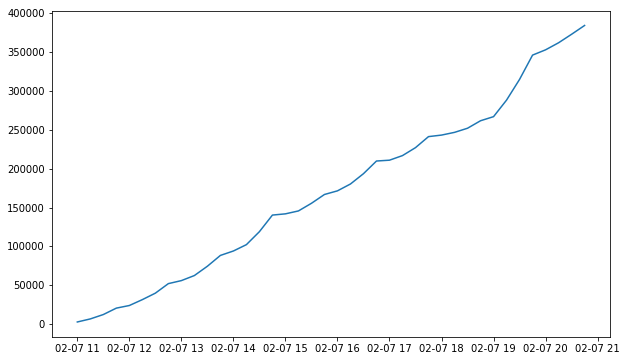

In [480]:

plt.plot(indexedDataset2)

HORA
2019-02-07 11:30:00   -0.570378
2019-02-07 11:45:00   -0.188386
2019-02-07 12:00:00   -1.173662
2019-02-07 12:15:00    9.571783
2019-02-07 12:30:00    1.007033
dtype: float64


HORA
2019-02-07 11:30:00    -0.570378
2019-02-07 11:45:00    -1.329141
2019-02-07 12:00:00    -3.261567
2019-02-07 12:15:00     4.377790
2019-02-07 12:30:00    13.024181
dtype: float64


C:\Users\marina.ripper\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


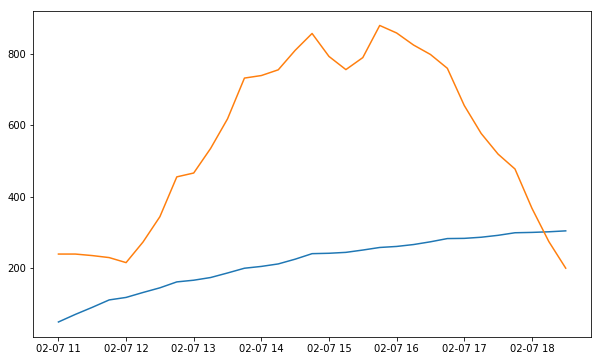